# TensorFlow-keras实战

课程代码的TF版本：大部分代码是tf2.0;课程以tf.keras API为主,因而部分代码可以在tf1.3+运行; 另有少量tf1.*版本代码

理论部分:

    1) TensorFlow-keras简介
    2) 分类问题、回归问题、损失函数
    3) 神经网络、激活函数、批归一化、Dropout
    4) Wide & deep 模型
    5) 超参数搜索

实战部分:
    
    1) keras搭建分类模型
    2) keras回调函数
    3) keras搭建回归模型
    4) keras 搭建深度神经网络
    5) keras 实现wide&deep模型
    6）keras 与scikit-learn实现超参数搜索

# 理论部分

Keras是什么？

    1) 基于python的高级神经网络API
    2) 以TensorFlow、CNTK或者Theano为后端运行, keras必须有后端才可以运行
        后端可以切换，现在多用tensorflow

TensorFlow-keras是什么?
    
    1) TensorFlow对Keras API规范的实现
    2）相对于以tensorflow为后端的keras,TensorFlow-keras 与TensorFlow结合更加紧密
    3）实现在tf.keras空间下
    
Tf-keras和keras联系

    1) 基于同一套API
        i)keras程序可以通过改导入方式轻松转化为tf.keras程序
        ii)反之可能不成立，因为tf.keras有其他特性
    2) 相同的JSON和HDF5模型序列化格式和语义
    
    
 Tf-keras和keras区别
 
     1） Tf.keras全面支持eager mode
        i)只是用keras.Sequential和Keras.Model时没有影响
        ii) 自定义Model内部运算逻辑的时候会有影响
           Tf底层API可以使用keras的model.fit等抽象
           适用于研究人员
     2）Tf.keras支持基于tf.data的模型训练
     3）Tf.keras支持TPU训练
     4）Tf.keras支持tf.distribution中的分布式策略
     5）其他特性
         Tf.keras可以与TensorFlow中的estimator集成
         Tf.keras可以保存为SavedModel
 
 如何选择？
     
     如果想用tf.keras的任何一个特性，那么选tf.keras
     如果后端互换性很重要，那么选keras
     如果都不重要，那随便  

## 分类问题与回归问题

1） 分类问题预测是类别，模型的输出是概率分布

    三分类的问题输出例子: [0.2, 0.7, 0.1]
    
2) 回归问题预测的是值，模型的输出是一个实数值


### 目标函数

为什么需要目标函数？

1) 参数是逐步调整的

2）目标函数可以帮助衡量模型的好坏

### 分类问题


    1）需要衡量目标函数类别与当前预测的差距
        三分类问题输出例子：[0.2, 0.7, 0.1]
        三分类真实类别: 2 -> one_hot -> [0, 0, 1]
    2) One-hot 编码，把正整数变为向量表达
        生成一个长度不小于正整数的向量，只有正整数的位置处为1，其余位置都为0
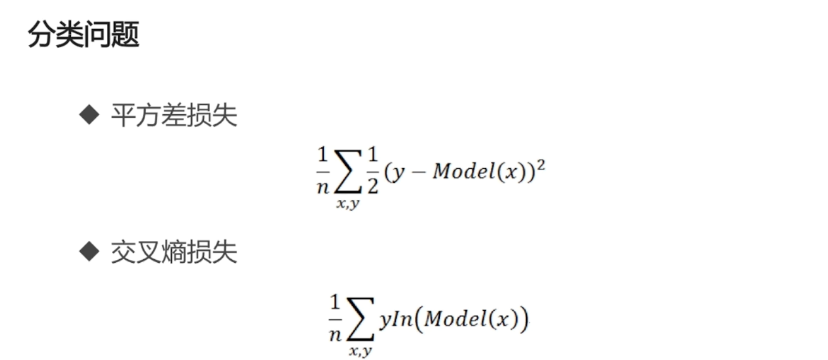

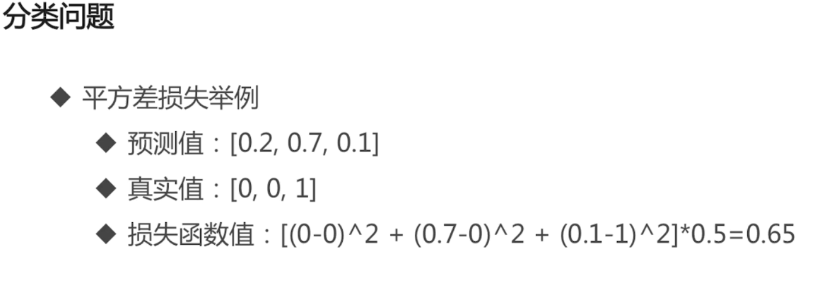

### 回归问题

1）预测值与真实值的差距

2）平方差损失

3）绝对值损失

模型的训练就是调整参数，使得目标函数逐渐变小的过程

# 实战

tf.keras分类模型

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os 
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)

for module in mpl,np,pd, sklearn,tf,keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)
matplotlib 2.2.2
numpy 1.19.2
pandas 0.23.0
sklearn 0.23.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist #手写数据集

(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
# 把数据划分为训练集、测试集
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]

y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


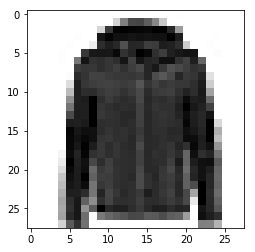

In [3]:
def show_single_image(img_arr):
    plt.imshow(img_arr, cmap="binary")
    plt.show()
    
    
show_single_image(x_train[0])

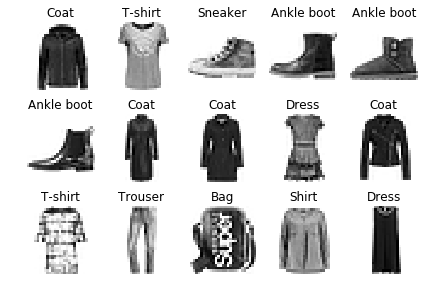

In [4]:
def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
    assert len(x_data) == len(y_data)
    assert n_rows * n_cols < len(x_data)
    plt.figure(figsize=(n_cols * 1.4, n_rows * 1.6))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col #为了输出1,2,3,4。。。
            plt.subplot(n_rows,n_cols, index+1) #定义n_rows× n_cols个子图，当前图像处于第index+1位置。
            plt.imshow(x_data[index], cmap="binary", interpolation="nearest") #cmap模式为灰白图像，插值方法为最近邻
            plt.axis('off') #关闭子图外廓
            plt.title(class_names[y_data[index]])
            
    plt.show()

class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot']


show_imgs(3, 5, x_train, y_train, class_names)         

# tf.keras.Sequential

In [5]:

# 激活函数：
# relu: y=max(0, x) 当x小于0则y=0,当x大于0则y为x
# softmax: 将向量变成概率分布， x=[x1, x2, x3]
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum= e^x1 + e^x2 + e^x3 

'''
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28,28]))
model.add(keras.layers.Dense(300, activation="relu")) #添加全连接层
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
'''

model = keras.models.Sequential([keras.layers.Flatten(input_shape = [28,28], 
                                keras.layers.Dense(300, activation="relu"),
                                keras.layers.Dense(100, activation="relu"),
                                keras.layers.Dense(10, activation="softmax")])
          
#当y为索引index是一个数则loss="sparse_categorical_crossentropy"
#当y为one_hot -> [] 则loss="categorical_crossentropy"
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

In [6]:
model.layers #输出层次

In [7]:
model.summary() #输出模型的架构和参数

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [8]:
# [None, 784] * w + b -> [None, 300];  
# w.shape 为[784, 300], b = [300]

In [9]:
# 对数据进行训练
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 73us/sample - loss: 294960116.2290 - accuracy: 0.0982 - val_loss: 2.3227 - val_accuracy: 0.0916
Epoch 2/10
55000/55000 [==============================] - 3s 58us/sample - loss: 2.3027 - accuracy: 0.0991 - val_loss: 2.3226 - val_accuracy: 0.1026
Epoch 3/10
55000/55000 [==============================] - 3s 56us/sample - loss: 2.3027 - accuracy: 0.0977 - val_loss: 2.3227 - val_accuracy: 0.1014
Epoch 4/10
55000/55000 [==============================] - 3s 56us/sample - loss: 2.3026 - accuracy: 0.0983 - val_loss: 2.3228 - val_accuracy: 0.1010
Epoch 5/10
55000/55000 [==============================] - 3s 56us/sample - loss: 2.3027 - accuracy: 0.0971 - val_loss: 2.3227 - val_accuracy: 0.0986
Epoch 6/10
55000/55000 [==============================] - 3s 56us/sample - loss: 2.3026 - accuracy: 0.0989 - val_loss: 2.3226 - val_accuracy: 0.0978
Epoch 7/10
55000/55000 [=========================

In [10]:
type(history) #输出类型

tensorflow.python.keras.callbacks.History

In [11]:
history.history

{'loss': [294960116.22899747,
  2.302657917404175,
  2.302655961712924,
  2.3026361827850343,
  2.3026588560277768,
  2.302643981101296,
  2.3026454399455676,
  2.3026558785525237,
  2.3026502481287174,
  2.302650060306896],
 'accuracy': [0.098163635,
  0.099054545,
  0.097745456,
  0.09829091,
  0.09709091,
  0.09885454,
  0.097109094,
  0.09890909,
  0.09887273,
  0.097272724],
 'val_loss': [2.3227015312194825,
  2.3226046131134033,
  2.322675092315674,
  2.32276081161499,
  2.3227301181793214,
  2.322608483886719,
  2.322663417816162,
  2.3226215095520018,
  2.3226984088897704,
  2.322619785308838],
 'val_accuracy': [0.0916,
  0.1026,
  0.1014,
  0.101,
  0.0986,
  0.0978,
  0.101,
  0.0916,
  0.1014,
  0.0988]}

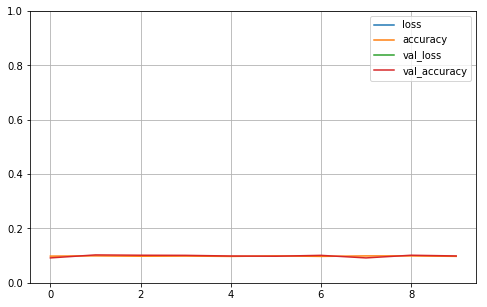

In [12]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True) #设置网格
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)